# `scikit-learn` wrapper speed tests

## Setup

Imports

In [1]:
import numba as nb
import numpy as np
import sklearn.linear_model

Create data

In [2]:
import patsy
import yatsm

cfg = yatsm.config_parser.parse_config_file('../../../examples/p022r049_example.yaml')
df = yatsm.utils.csvfile_to_dataframe(cfg['dataset']['input_file'])

Y = yatsm.reader.read_pixel_timeseries(df['filename'], 50, 50)

In [3]:
from yatsm.regression.transforms import harm

model = '1 + x + harm(x, 1)'
X = patsy.dmatrix(model, {'x': df['date']})

In [4]:
mask = np.in1d(Y[-1, :], [0, 1])

Y = Y[:-1, mask]
X = X[mask, :]

y = Y[4, :]

Fit model

In [5]:
model = sklearn.linear_model.LassoCV()

In [6]:
model.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

## Timings:

### 1. prediction

In [62]:
%timeit model.predict(X)

The slowest run took 6.11 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 17.7 µs per loop


In [63]:
def pred(X, coef, intercept):
    return X.dot(coef) + intercept

@nb.jit()
def nb_pred(X, coef, intercept):
    return X.dot(coef) + intercept

In [61]:
%timeit pred(X, model.coef_, model.intercept_)

The slowest run took 14.05 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.34 µs per loop


In [60]:
%timeit nb_pred(X, model.coef_, model.intercept_)

The slowest run took 17.61 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.53 µs per loop


And they give the same result:

In [59]:
np.testing.assert_allclose(model.predict(X),
                           pred(X, model.coef_, model.intercept_)) 

#### Conclusion: 
NumPy dot product is faster than `sklearn`'s predict method, but don't use Numba since Numba doesn't accelerate it

### 2. RMSE

In [7]:
yhat = model.predict(X)

In [8]:
%timeit sklearn.metrics.mean_squared_error(y, yhat) ** 0.5

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 48 µs per loop


In [20]:
def rmse(y, yhat):
    return ((y - yhat) ** 2).mean() ** 0.5

@nb.jit()
def nb_rmse(y, yhat):
    return ((y - yhat) ** 2).mean() ** 0.5

In [21]:
%timeit rmse(y, yhat)

The slowest run took 7.27 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 7.15 µs per loop


In [18]:
%timeit nb_rmse(y, yhat)

The slowest run took 10.90 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 743 ns per loop


In [17]:
np.testing.assert_allclose(sklearn.metrics.mean_squared_error(y, yhat) ** 0.5,
                           nb_rmse(y, yhat))

#### Conclusion:
Numba does very well accelerating RMSE calculation as it can be run in `nopython` mode.

Numba is 10x faster than NumPy solution and NumPy solution is 7x faster than `sklearn`.

### Dynamic RMSE

Example code:
``` python
def _get_dynamic_rmse(self):
    """ Return the dynamic RMSE for each model

    Dynamic RMSE refers to the Root Mean Squared Error calculated using
    `self.min_obs` number of observations closest in day of year to the
    observation `self.consecutive` steps into the future. Goal is to
    reduce false-positives during seasonal transitions (high variance in
    the signal) while decreasing omission during stable times of year.

    Returns:
      np.ndarray: NumPy array containing dynamic RMSE of each tested model

    """
    # Indices of closest observations based on DOY
    i_doy = np.argsort(np.mod(
        self.X[self.start:self.here, self.i_x] -
        self.X[self.here + self.consecutive, self.i_x],
        self.ndays))[:self.min_obs]

    rmse = np.zeros(len(self.test_indices), np.float32)
    for i_b, b in enumerate(self.test_indices):
        m = self.models[b]
        rmse[i_b] = np.sqrt(np.sum(
            (self.Y[b, :].take(i_doy) -
                m.predict(self.X.take(i_doy, axis=0))) ** 2)
            / i_doy.size)

    return rmse
```

In [132]:
dates = X[:, 1].astype(np.uint32)
today = dates[10]

In [158]:
from datetime import datetime as dt

def dt_get_closest_doy(today, dates, n_obs):
    """ Return `n_obs` dates with DOY closest to DOY of `today`
    
    Reference implementation using datetime to ensure correct date->DOY
    
    Args:
        today (int): ordinal date for day in question
        dates (np.ndarray): all ordinal dates
        n_obs (int): number of dates to return
        
    Returns:
        np.ndarray: `n_obs` indices of `dates` for observations 
            closest to `today`
    """
    today_doy = dt.fromordinal(today).timetuple().tm_yday
    dates_doy = np.array([dt.fromordinal(d).timetuple().tm_yday for d in dates])
    
    return np.argsort(np.abs(dates_doy - today_doy))[:n_obs]

def np_get_closest_doy(today, dates, n_obs):
    """ Return `n_obs` dates with DOY closest to DOY of `today`
    
    Approximation using 365.25 and modulo
    
    Args:
        today (int): ordinal date for day in question
        dates (np.ndarray): all ordinal dates
        n_obs (int): number of dates to return
        
    Returns:
        np.ndarray: `n_obs` indices of `dates` for observations 
            closest to `today`
    """
    return np.argsort(np.mod(np.abs(dates - today), 365.25))[:n_obs]

def zz_get_closest_doy(today, dates, n_obs):
    """ Zhu's implementation
    
    Should be similar to YATSM implementation -- approximation using 365.25.
    Not technically correct but hopefully faster
    """
    d_diff = dates - today
    return np.argsort(np.abs(np.round(d_diff / 365.25) * 365.25 - d_diff))[:n_obs]

In [143]:
dt.fromordinal(today).timetuple().tm_yday

281

In [159]:
test_dt = dt_get_closest_doy(today, dates, 20)
test_np = np_get_closest_doy(today, dates, 20)
test_zz = zz_get_closest_doy(today, dates, 20)

In [137]:
def to_doy(dates):
    return np.array([dt.fromordinal(d).timetuple().tm_yday for d in dates])

In [150]:
print(sorted(to_doy(dates[test_dt])))

[268, 269, 274, 276, 278, 281, 284, 285, 287, 288, 288, 290, 290, 290, 293, 295, 297, 298, 298, 301]


In [151]:
print(sorted(to_doy(dates[test_np])))

[73, 89, 281, 284, 285, 287, 288, 288, 290, 290, 290, 293, 295, 297, 298, 298, 301, 303, 304, 304]


In [149]:
print(sorted(to_doy(dates[test_zz])))

[57, 73, 268, 269, 274, 276, 278, 281, 284, 285, 287, 288, 288, 290, 290, 290, 293, 295, 297, 298]


In [167]:
%timeit test_dt = dt_get_closest_doy(today, dates, 20)
%timeit test_np = np_get_closest_doy(today, dates, 20)
%timeit test_zz = zz_get_closest_doy(today, dates, 20)

1000 loops, best of 3: 278 µs per loop
100000 loops, best of 3: 9.9 µs per loop
100000 loops, best of 3: 14.2 µs per loop


In [164]:
from datetime import datetime as dt

@nb.jit
def nb_dt_get_closest_doy(today, dates, n_obs):
    """ Return `n_obs` dates with DOY closest to DOY of `today`
    
    Reference implementation using datetime to ensure correct date->DOY
    
    Args:
        today (int): ordinal date for day in question
        dates (np.ndarray): all ordinal dates
        n_obs (int): number of dates to return
        
    Returns:
        np.ndarray: `n_obs` indices of `dates` for observations 
            closest to `today`
    """
    today_doy = dt.fromordinal(today).timetuple().tm_yday
    dates_doy = np.empty_like(dates)
    for i in range(len(dates)):
        dates_doy[i] = dt.fromordinal(d).timetuple().tm_yday
    
    return np.argsort(np.abs(dates_doy - today_doy))[:n_obs]

@nb.jit
def nb_np_get_closest_doy(today, dates, n_obs):
    """ Return `n_obs` dates with DOY closest to DOY of `today`
    
    Approximation using 365.25 and modulo
    
    Args:
        today (int): ordinal date for day in question
        dates (np.ndarray): all ordinal dates
        n_obs (int): number of dates to return
        
    Returns:
        np.ndarray: `n_obs` indices of `dates` for observations 
            closest to `today`
    """
    return np.argsort(np.mod(np.abs(dates - today), 365.25))[:n_obs]

@nb.jit
def nb_zz_get_import numba as nb
import numpy as np
import sklearn.linear_modelclosest_doy(today, dates, n_obs):
    """ Zhu's implementation
    
    Should be similar to YATSM implementation -- approximation using 365.25.
    Not technically correct but hopefully faster
    """
    d_diff = dates - today
    return np.argsort(np.abs(np.round(d_diff / 365.25) * 365.25 - d_diff))[:n_obs]

In [175]:
from numba import uint8, uint16, uint32

In [216]:
@nb.njit()
def partition(values, idxs, left, right):
    """
    Partition method
    """

    piv = values[idxs[left]]
    i = left + 1
    j = right

    while True:
        while i <= j and values[idxs[i]] <= piv:
            i += 1
        while j >= i and values[idxs[j]] >= piv:
            j -= 1
        if j <= i:
            break

        idxs[i], idxs[j] = idxs[j], idxs[i]

    idxs[left], idxs[j] = idxs[j], idxs[left]

    return j

@nb.njit()
def argsort1D(values):

    idxs = np.arange(values.shape[0])

    left = 0
    right = values.shape[0] - 1

    max_depth = np.int(right / 2)

    ndx = 0

    tmp = np.zeros((max_depth, 2), dtype=np.int64)

    tmp[ndx, 0] = left
    tmp[ndx, 1] = right

    ndx = 1
    while ndx > 0:

        ndx -= 1
        right = tmp[ndx, 1]
        left = tmp[ndx, 0]

        piv = partition(values, idxs, left, right)

        if piv - 1 > left:
            tmp[ndx, 0] = left
            tmp[ndx, 1] = piv - 1
            ndx += 1

        if piv + 1 < right:
            tmp[ndx, 0] = piv + 1
            tmp[ndx, 1] = right
            ndx += 1

    return idxs

In [218]:
@nb.jit(uint16[:](uint32, uint16[:], uint8))
def nb_np_get_closest_doy(today, dates, n_obs):
    return argsort1D(np.fmod(np.abs(dates - today), 365.25))[:n_obs].astype(np.uint16)

In [193]:
20

numpy.uint32

In [219]:
nb_np_get_closest_doy(today, dates, 20).dtype

dtype('uint16')

In [220]:
nb_np_get_closest_doy.inspect_types()

nb_np_get_closest_doy (uint32, array(uint16, 1d, A), uint8)
--------------------------------------------------------------------------------
# File: <ipython-input-218-c19cde3eedb9>
# --- LINE 1 --- 

@nb.jit(uint16[:](uint32, uint16[:], uint8))

# --- LINE 2 --- 

def nb_np_get_closest_doy(today, dates, n_obs):

    # --- LINE 3 --- 
    # label 0
    #   today = arg(0, name=today)  :: pyobject
    #   dates = arg(1, name=dates)  :: pyobject
    #   n_obs = arg(2, name=n_obs)  :: pyobject
    #   $0.1 = global(argsort1D: CPUOverloaded(<function argsort1D at 0x7fbd282b1c08>))  :: pyobject
    #   $0.2 = global(np: <module 'numpy' from '/home/ceholden/venv/lib/python2.7/site-packages/numpy/__init__.pyc'>)  :: pyobject
    #   $0.3 = getattr(attr=fmod, value=$0.2)  :: pyobject
    #   del $0.2
    #   $0.4 = global(np: <module 'numpy' from '/home/ceholden/venv/lib/python2.7/site-packages/numpy/__init__.pyc'>)  :: pyobject
    #   $0.5 = getattr(attr=abs, value=$0.4)  :: pyobject
    #   

In [221]:
%timeit test_dt = nb_dt_get_closest_doy(today, dates, 20)
%timeit test_np = nb_np_get_closest_doy(today, dates, 20)
%timeit test_zz = nb_zz_get_closest_doy(today, dates, 20)

1000 loops, best of 3: 243 µs per loop
10000 loops, best of 3: 57.2 µs per loop
The slowest run took 4.22 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 15.9 µs per loop


## Patsy & Model Specification

In [77]:
np.argsortdef sim_lm(n, m):
    return np.arange(n) * (m + np.random.rand(n))

y, X_int = patsy.dmatrices('y ~ x1 + x2', {'y': sim_lm(n, 3), 'x1': sim_lm(n, 0.1), 'x2': sim_lm(n, 1.2)})
X = X_int[:, 1:]

In [96]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [97]:
yhat_int = sklearn.linear_model.Lasso(fit_intercept=False).fit(X_int, y).predict(X_int)
yhat = sklearn.linear_model.Lasso().fit(X, y).predict(X)

<IPython.core.display.Javascript object>


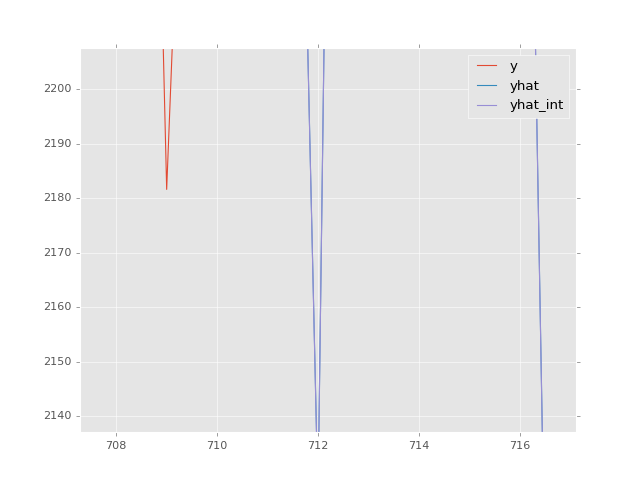

In [104]:
%matplotlib nbagg
plt.plot(y, label='y')
plt.plot(yhat, label='yhat')
plt.plot(yhat_int, label='yhat_int')
plt.legend()

In [134]:
if X_int.design_info.column_name_indexes.get('Intercept') is not None: print 'yes'

yes


In [127]:
np.delete(X_int, X_int.design_info.column_name_indexes['Intercept'], axis=1)

array([[  0.00000000e+00,   0.00000000e+00],
       [  9.61617644e-01,   1.72287668e+00],
       [  1.44073678e+00,   3.55919637e+00],
       ..., 
       [  5.00204895e+02,   1.25927154e+03],
       [  4.65040128e+02,   1.87224453e+03],
       [  4.77629588e+02,   2.02241352e+03]])

In [ ]:
lasso.nobs = Y[b, :].size
lasso.coef = np.copy(lasso.coef_)
lasso.coef[0] += lasso.intercept_
lasso.fittedvalues = lasso.predict(X)
lasso.rss = np.sum((Y[b, :] - lasso.fittedvalues) ** 2)
lasso.rmse = math.sqrt(lasso.rss / lasso.nobs)